In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
import os
import scipy.stats
from matplotlib import cm
import dask
import pickle
from datetime import datetime
from functools import reduce
import ast

In [2]:
def spliter(value, array):
    res = []
    while value in array:
        index = array.index(value)
        res.append(array[:index + 1])
        array = array[index + 1:]
    if array:
        # Append last elements
        res.append(array)
    return res

In [3]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [4]:
import warnings
warnings.simplefilter("ignore")
#annoying cftime serialization warning 

In [5]:
models = [x.split('/')[-1] for x in glob.glob("/terra/data/cmip5/global/rcp85/*")]   

In [6]:
dic = {}
for model in models:
    try:
        rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/pr_*"))
        rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
        rcp85 = rcp85.sel(time = slice('2000','2250'))
        hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/mon/native/pr_*"))
        hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
        x = xr.concat([hist,rcp85],dim='time').load()
        x = x.sortby(x.time)
        x = x.resample(time='M').mean()
        dic[model] = x.load()
    except:
        if model == 'BNU-ESM':  # no historical monthly data 
            rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/pr_*"))
            rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
            rcp85 = rcp85.sel(time = slice('2000','2250'))
            hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/day/native/pr_*"))
            hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
            hist = hist.resample(time='M').mean()
            x = xr.concat([hist,rcp85],dim='time').load()
            x = x.sortby(x.time)
            x = x.resample(time='M').mean()
            dic[model] = x.load()
        elif model == 'MPI-ESM-LR':  # a problem with the later than 2100 data
            rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/pr_*"))[0]
            rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
            rcp85 = rcp85.sel(time = slice('2000','2250'))
            hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/mon/native/pr_*"))
            hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
            x = xr.concat([hist,rcp85],dim='time').load()
            x = x.sortby(x.time)
            x = x.resample(time='M').mean()
            dic[model] = x.load()
        elif model == 'CNRM-CM5': # a problem with the later than 2100 data
            rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/pr_*"))[:2]
            rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
            rcp85 = rcp85.sel(time = slice('2000','2250'))
            hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/mon/native/pr_*"))
            hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
            x = xr.concat([hist,rcp85],dim='time').load()
            x = x.sortby(x.time)
            x = x.resample(time='M').mean()
            dic[model] = x.load()
        else:
            print(model)

EC-EARTH
CESM1-WACCM


In [7]:
#ERA5
x = xr.open_mfdataset(sorted(glob.glob('/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5/day/native/pr_*')), decode_cf=True).sel(latitude = -34, method = 'nearest').sel(longitude = 18, method = 'nearest').pr
x = x.sortby(x.time)
x = x.resample(time='M').mean()
dic['ERA5'] = x.load()

In [8]:
x = xr.open_mfdataset('/home/pmarsh/NOAA_2deg/prate.mon.mean.nc', decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').prate
x = x.sortby(x.time)
x = x.resample(time='M').mean()
dic['NOAA'] = x.load()

In [72]:
spi_dic={}
for model in dic:
    x = dic[model].dropna(dim='time').sel(time = slice('1950','2100'))
    df = pd.DataFrame(np.array([pd.date_range(start='1950/01/01', periods=len(x), freq='M')]).T, columns = ['date']) # fake dates to deal with no leap-year models - BNU-ESM
    df['pr'] = x.values
    from standard_precip import spi
    spi = spi.SPI()
    df, precip_cols = spi.rolling_window_sum(df, ['pr'], 12)
    spi._df_copy = df[['date'] + precip_cols].copy()
    spi._df_copy['date'] = pd.to_datetime(spi._df_copy['date'])
    spi.freq_col = 'M'
    spi._df_copy[spi.freq_col] = spi._df_copy['date'].dt.month
    freq_range = spi._df_copy[spi.freq_col].unique().tolist()
    # Loop over months
    dfs = []
    dfs_p = pd.DataFrame()
    for j in freq_range:
        precip_all = spi._df_copy.loc[spi._df_copy['M']==j]
        precip_single_df = precip_all.dropna().copy()
        precip_single = precip_single_df['pr_scale_12'].values
        precip_sorted = np.sort(precip_single)[::-1]
        # Fit distribution for particular series and month
        params, p_zero = spi.fit_distribution(precip_sorted[:50], 'gam', 'lmom') # here is where the package has been edited to only fit distrobution to first 50 years
        # Calculate SPI/SPEI
        spi_ = spi.cdf_to_ppf(precip_single, params, p_zero)
        idx_col = "spi"
        precip_single_df[idx_col] = spi_
        precip_single_df = precip_single_df[['date', idx_col]]
        dfs_p = pd.concat([dfs_p, precip_single_df])
        dfs_p = dfs_p.sort_values('date')
    dfs.append(dfs_p)
    df_all = reduce(lambda left, right: pd.merge(left, right, on='date', how='left'), dfs, spi._df_copy)
    df_all = df_all.drop(columns=spi.freq_col)
    df['spi'] = df_all.spi   
    spi_dic[model] = df

In [73]:
for index in spi_dic:
    drought_len = [0]*12
    for i in range(12,len(spi_dic[index])):
        if drought_len[i-1] > 0:
            if spi_dic[index].spi[i] > 0.2:
                drought_len.append(0)
            else:
                drought_len.append(drought_len[i-1]+1)
        elif spi_dic[index].spi[i] < -0.8:
            drought_len.append(drought_len[i-1]+1)
        else:
            drought_len.append(0)
    spi_dic[index]['drought'] = drought_len

In [74]:
for index in spi_dic:
    spi_dic[index].drought[spi_dic[index].drought <= 24] = 0
    spi_dic[index].drought[spi_dic[index].drought > 0] = 1
    spi_dic[index]['drought_rolled'] = spi_dic[index].drought.rolling(240).mean()

In [75]:
cmip = list(dic.keys())[:-2]

results = pd.read_csv('../../scores/results.csv').set_index('Model')
considered = [model for model in results.index if model in cmip]

winners = ['MIROC-ESM-CHEM' , 'BNU-ESM' , 'CNRM-CM5' , 'ACCESS1-0', 'GFDL-CM3', 'bcc-csm1-1-m'] # -m if rcp85 

In [76]:
cmip_hist=[]
considered_hist=[]
winners_hist=[]
for index in cmip:
    x = spi_dic[index].set_index('date')['2005/12'].drought_rolled[0]
    if index in winners:
        cmip_hist.append(x)
        considered_hist.append(x)
        winners_hist.append(x)
    elif index in considered:
        cmip_hist.append(x)
        considered_hist.append(x)
    else:
        cmip_hist.append(x)

In [80]:
winners = [model for model in cmip if model in winners]
considered = [model for model in cmip if model in considered]

In [82]:
cmip_rcp=[]
considered_rcp=[]
winners_rcp=[]
for index in cmip:
    x = spi_dic[index].set_index('date')['2060/12'].drought_rolled[0]
    if index in winners:
        cmip_rcp.append(x)
        considered_rcp.append(x)
        winners_rcp.append(x)
    elif index in considered:
        cmip_rcp.append(x)
        considered_rcp.append(x)
    else:
        cmip_rcp.append(x)

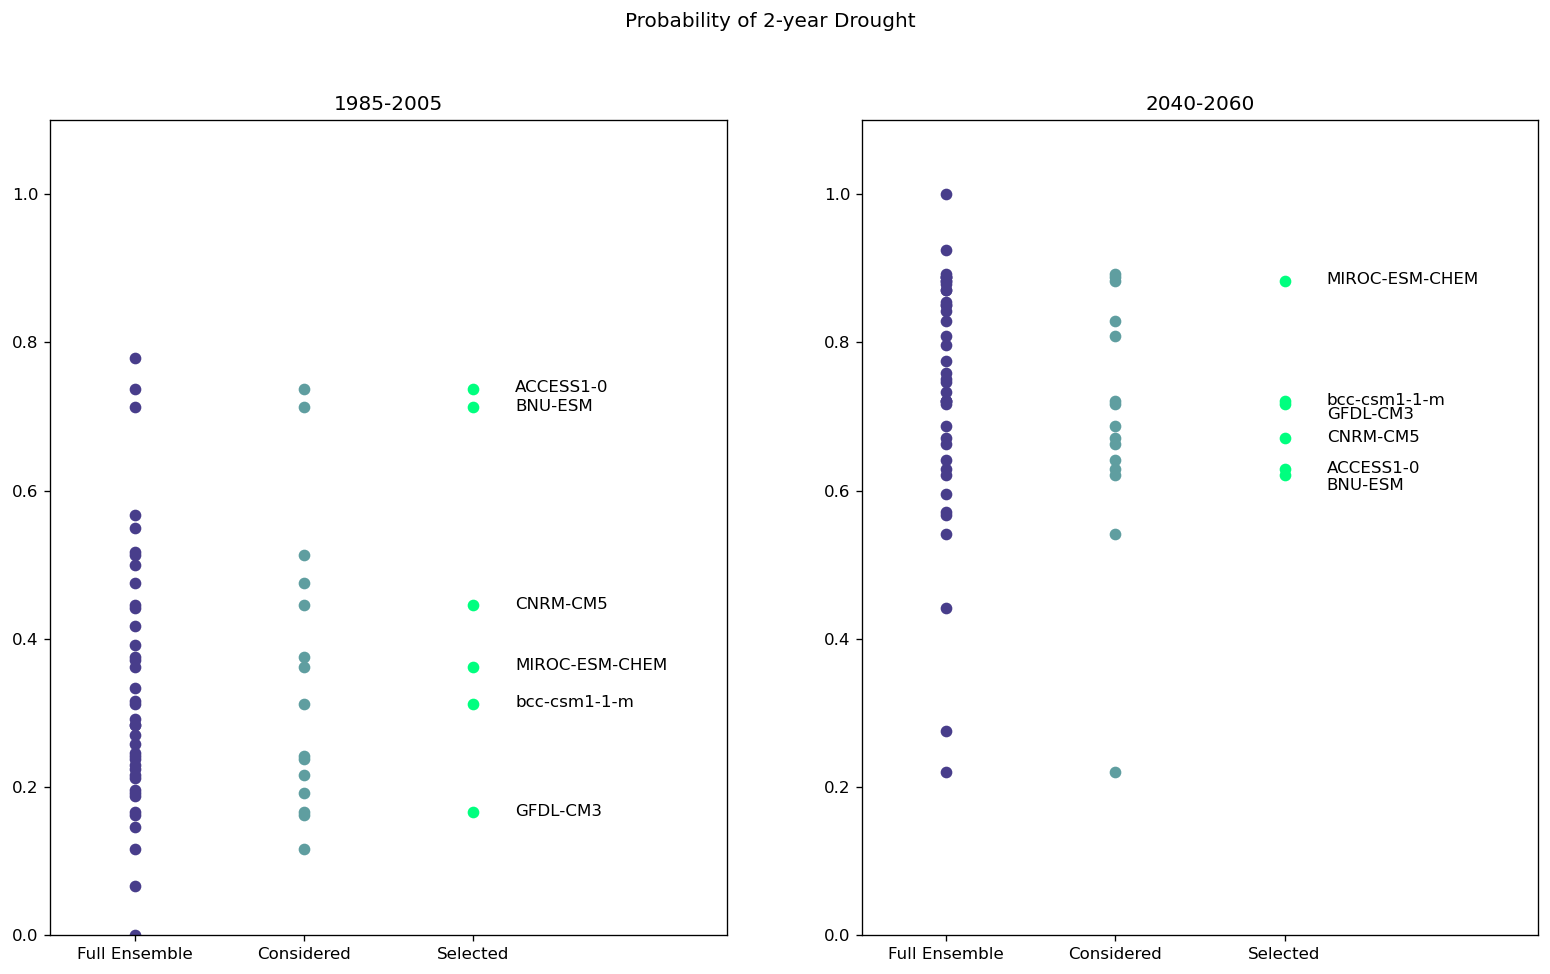

In [92]:
fig,ax = plt.subplots(figsize=(16, 9),dpi = 120)
fig.suptitle('Probability of 2-year Drought')
ax = plt.subplot(1, 2, 1)
plt.title('1985-2005')
ax.set_ylim(0,1.1)
ax.set_xlim(0,0.8)
for model,x in zip(cmip, cmip_hist):
    plt.scatter(0.1,x,color = 'darkslateblue')
for model,x in zip(considered, considered_hist):
    plt.scatter(0.3,x,color = 'cadetblue')
for model,x in zip(winners, winners_hist):
    plt.scatter(0.5,x,color = 'springgreen')
for model,x in zip(winners, winners_hist):
    plt.text(0.55,x-0.005,str(model))
plt.xticks([0.1,0.3,0.5], labels = ['Full Ensemble','Considered','Selected'])

ax2 = plt.subplot(1, 2, 2)
plt.title('2040-2060')
ax2.set_ylim(0,1.1)
ax2.set_xlim(0,0.8)
for model,x in zip(cmip, cmip_rcp):
    plt.scatter(0.1,x,color = 'darkslateblue')
for model,x in zip(considered, considered_rcp):
    plt.scatter(0.3,x,color = 'cadetblue')
for model,x in zip(winners, winners_rcp):
    plt.scatter(0.5,x,color = 'springgreen')
for model,x in zip(winners, winners_rcp):
    if model == 'BNU-ESM':
      plt.text(0.55,x-0.02,str(model))
    elif model == 'GFDL-CM3':
        plt.text(0.55,x-0.02,str(model))
    else:
        plt.text(0.55,x-0.005,str(model))
plt.xticks([0.1,0.3,0.5], labels = ['Full Ensemble','Considered','Selected'])
plt.savefig('SPI_drought_shit.pdf')
plt.savefig('SPI_drought_shit.png')



<AxesSubplot:xlabel='date'>

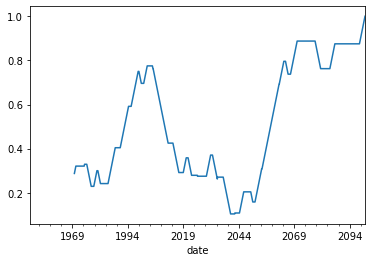

In [85]:
spi_dic['ACCESS1-0'].set_index('date').drought_rolled.plot()

<AxesSubplot:xlabel='date'>

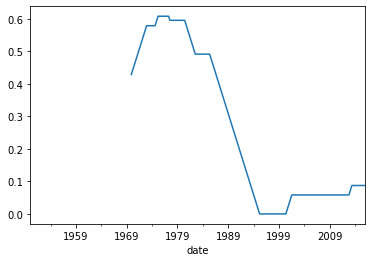

In [86]:
spi_dic['NOAA'].set_index('date').drought_rolled.plot()

<AxesSubplot:xlabel='date'>

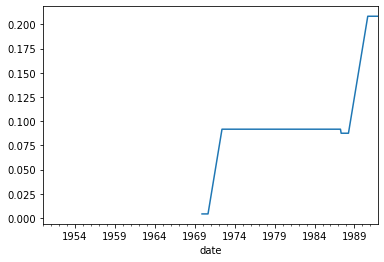

In [87]:
spi_dic['ERA5'].set_index('date').drought_rolled.plot()